# Challenge
Let's do a little scraping or API-calling of our own. We'll pick a website and see what we can get out of it. 
Formally, our goal is to write a scraper that will:

1. Return specific pieces of information (rather than just downloading a whole page)
2. Iterate over multiple pages/queries
3. Save the data to your computer

Once we have our data, we will compute some statistical summaries and/or visualizations that give us some new insights into our scraping topic of interest. 

## Get List of Links

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import itertools
import re

main_url = 'https://www.disneyclips.com/lyrics/'

res = urlopen(main_url)
html_code = res.read()

soup = BeautifulSoup(html_code)

movie_links = []
for link in soup.findAll('a', attrs={'href': re.compile(r"\.html$")}):
    movie_links.append(link.get('href'))

regex = re.compile(r'^(?!https)')
movie_links = list(filter(regex.search, movie_links))

movie_links = [main_url + link for link in movie_links]

song_links = []
for movie_link in movie_links:
    res = urlopen(movie_link)
    html_code = res.read()
    soup = BeautifulSoup(html_code)
    
    sub_links = []
    for link in soup.findAll('a', attrs={'href': re.compile(r"\.html$")}):
        sub_links.append(link.get('href'))
        
    sub_links = list(filter(regex.search, sub_links))
    
    if len(sub_links) == 0:
        song_links.append(movie_link)
    
    else:
        for link in sub_links:
            song_links.append(main_url + link)

len(song_links)

728

## Data Extraction via Scrapy

In [2]:
import scrapy
from scrapy.crawler import CrawlerProcess
import pandas as pd


class LyricSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "lyrics"
    
    # URL(s) to start with.
    start_urls = [
        song_links[0],
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every element on the page.
        for song in response.xpath('//div[@class="main"]'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code to choose what we want to extract
                # You can modify this with other Xpath expressions to extract other information from the site
                'song_name': song.xpath('h1/text()').extract_first(),
                'movie_name': song.xpath('p[@class="info"]/a/u/text()').extract_first() if song.xpath('p[@class="info"]/a/u/text()') else song.xpath('p[@class="info"]/text()').extract()[0].split(' from ')[1],
                #'composer(s)': ', '.join(song.xpath('p[@class="info"]/text()').extract()[1].split(' by ')[1:]) if (len(song.xpath('p[@class="info"]/text()').extract())==4) else "N/A",
                'writer(s)': ', '.join(song.xpath('p[@class="info"]/text()').extract()[1].split(' by ')[1:]) if (len(song.xpath('p[@class="info"]/text()').extract())==3) else ', '.join(song.xpath('p[@class="info"]/text()').extract()[2].split(' by ')[1:]) if (len(song.xpath('p[@class="info"]/text()').extract())==4) else "N/A",
                'performer(s)': ', '.join(song.xpath('p[@class="info"]/text()').extract()[2].split(' by ')[1:]) if (len(song.xpath('p[@class="info"]/text()').extract())==3) else ', '.join(song.xpath('p[@class="info"]/text()').extract()[3].split(' by ')[1:]) if (len(song.xpath('p[@class="info"]/text()').extract())==4) else ', '.join(song.xpath('p[@class="info"]/text()').extract()[1].split(' by ')[1:]),
                'lyrics': ' \n'.join(song.xpath('p/text()').extract()[3:]) if (len(song.xpath('p[@class="info"]/text()').extract())==3) else ' \n'.join(song.xpath('p/text()').extract()[4:]) if (len(song.xpath('p[@class="info"]/text()').extract())==4) else ' \n'.join(song.xpath('p/text()').extract()[2:]),
            }

        for link in song_links:
            yield scrapy.Request(link, callback=self.parse)

process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'lyricsfinal.json',
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False
})  


# Starting the crawler with our spider.
process.crawl(LyricSpider)
process.start()
print('Success!')

Success!


In [108]:
import pandas as pd

songs = pd.read_json('lyricsfinal.json', orient='records')
print(songs.shape)
songs.head()

(727, 5)


,lyrics,movie_name,performer(s),song_name,writer(s)
0,Cruella De Vil \nCruella De Vil \nIf she doesn...,101 Dalmatians,Bill Lee as Roger,Cruella De Vil,Mel Leven
1,"Yeah, another one \nYou know it's Will Smith a...",Aladdin (Live-Action),Will Smith and DJ Khaled,Friend Like Me (End Title),Alan Menken and Howard Ashman
2,"Here I go, woo! \nBack up! \nWatch out! \nYou ...",Aladdin (Live-Action),Will Smith as Genie,Friend Like Me,Alan Menken and Howard Ashman
3,"[Zayn:] I can show you the world \nShining, sh...",Aladdin (Live-Action),Zayn Malik and Zhavia Ward,A Whole New World (End Title),Alan Menken and Tim Rice
4,"[Aladdin:] I can show you the world \nShining,...",Aladdin (Live-Action),Mena Massoud as Aladdin and Naomi Scott as Jas...,A Whole New World,Alan Menken and Tim Rice


## Dataset Analysis
### Unique Writer Names

In [99]:
import numpy as np
unique_writers = np.unique([name.split(';')[0].split(' as')[0].strip() for names in [item.replace(', ', ' and ').replace(' & ', ' and ').split('and ') for item in songs['writer(s)']] for name in names])
unique_writers = unique_writers[1:-3]
unique_writers

array(['A.A. Milne', 'Aaron Dudley', 'Adam Anders', 'Adam Schlesinger',
       'Adam Watts', 'Adam Young', 'Adrian Molina', 'Agustín Lara',
       'Al Cameron', 'Al Hoffman', 'Al Kasha', 'Al Sack', 'Alan Menken',
       'Alan Silvestri', 'Alan Zachary', 'Alana Da Fonseca',
       'Alec Wilder', 'Alex Mandel', 'Alexa Junge', 'Ali "Dee" Theodore',
       'Ali Dee', 'Ali Dee Theodore', 'Ali Payami', 'Allie Wrubel',
       'Amy Powers', 'Andrew Hale', 'Andrew Lippa', 'Andrew McMahon',
       'Andy Dodd', 'Anthony Mirabella', 'Antonina Armato',
       'Ariana Grande', 'Aris Archontis', 'Arthur Johnston',
       'Arthur Quenzer', 'Audra McDonald', 'Ayn Robbins', 'Barry Manilow',
       'Barry Mann', 'Beau Black', 'Ben Travers', 'Benj Pasek',
       'Bennie Benjamin', 'Beyoncé', 'Bill Walsh', 'Blair Masters',
       'Blaise Tosti', 'Bob Hilliard', 'Bobby Worth', 'Brad Paisley',
       'Brendan Milburn', 'Brian Hohlfeld', 'Brian Lee', 'Brian Smith',
       'Bridget Benenate', 'Brittany Coney',

### Unique Performer Names

In [34]:
unique_performers = np.unique([name.split(';')[0].split('(')[0].split(' as')[0].strip() for names in [item.replace(', ', ' and ').replace(' & ', ' and ').replace('with ', 'and ').replace('featuring ', 'and ').split('and ') for item in songs['performer(s)']] for name in names])
unique_performers = unique_performers[1:]
unique_performers

array(['98 Degrees', 'Aaron Lohr', 'Aaron Spaan', 'Aaryn Doyle',
       'Adam S. Shen', 'Adriana Caselotti', 'Agatha Lee Monn',
       'Aimee Carrero', 'Al Hoffman', 'Al Rinker', 'Alan Menken',
       'Alana D', 'Alanna Ubach', 'Alec Murphy', 'Alessia Cara',
       'Ali Dee Theodore', 'Alison Krauss', 'All 4 One', 'Alyson Stoner',
       'Amy Adams', 'Ana Gasteyer', 'Ana Ofelia Murguía',
       'Andre Sogliuzzo', 'Andrea Robinson', 'Andrew Keenan-Bolger',
       'Andrew Kishino', 'Andrew McMahon in the Wilderness', 'Andy Dick',
       'Andy Russell', 'Angela Lansbury', 'Anika Noni Rose',
       'Anita Gordon', 'Anna Camp', 'Anna Cathcart',
       'Anna Maria Perez de Tagle', 'Anthony Callea', 'Anthony Gonzalez',
       'Anthony Mirabella', 'Antonio Sol', 'Ariel Winter', 'Arthur Malet',
       'Ary Barroso', 'Ashley Eckstein', 'Ashley Tisdale',
       "Auli'i Cravalho", 'Avril Lavigne', 'BBMak', 'Barbara Dirickson',
       'Barbara Luddy', 'Beau Black', 'Ben Taylor', 'Ben Whishaw',
    

## Feature Engineering
### Has a Sequel?

In [ ]:
movie_list = np.unique(songs['movie_name'])
movie_list

In [ ]:
sorted_movies = sorted(movie_list, key=len)
sorted_movies

In [69]:
sequel_groups = [[movie_list[i] for i,val in enumerate([sorted_movies[j] in item for item in movie_list]) if val==True] for j in range(len(sorted_movies))]
sequel_groups = [group for group in sequel_groups if len(group)>1]
sequel_groups

[['Cars', 'Cars 3'],
 ['Bambi', 'Bambi II'],
 ['Mulan', 'Mulan 2'],
 ['Frozen', 'Frozen Fever', "Olaf's Frozen Adventure"],
 ['Planes', 'Planes: Fire and Rescue'],
 ['Tarzan', 'Tarzan II'],
 ['Aladdin',
  'Aladdin (Live-Action)',
  'Aladdin and the King of Thieves',
  'Aladdin: The Return of Jafar'],
 ['Tangled', 'Tangled Before Ever After'],
 ['Camp Rock', 'Camp Rock 2: The Final Jam'],
 ['Beauty and the Beast: The Enchanted Christmas', 'Enchanted'],
 ['Peter Pan', 'Peter Pan II: Return to Neverland'],
 ['Cinderella',
  'Cinderella (2015)',
  'Cinderella 2 Dreams Come True',
  'Cinderella III A Twist in Time'],
 ['Pocahontas', 'Pocahontas II: Journey to a New World'],
 ['Toy Story ', 'Toy Story 2', 'Toy Story 3', 'Toy Story 4'],
 ['Tinker Bell',
  'Tinker Bell and The Great Fairy Rescue',
  'Tinker Bell and the Legend of the NeverBeast',
  'Tinker Bell: Secret of the Wings'],
 ['Brother Bear', 'Brother Bear II'],
 ['Mary Poppins', 'Mary Poppins Returns'],
 ["Pete's Dragon", "Pete's Dr

In [107]:
within_a_series = [title for groups in sequel_groups for title in groups]
within_a_series.remove('Enchanted')   #Was accidentally included because of B&B: Enchanted Christmas
within_a_series = list(np.unique(within_a_series))
within_a_series

['101 Dalmatians',
 "101 Dalmatians 2: Patch's London Adventure",
 'Aladdin',
 'Aladdin (Live-Action)',
 'Aladdin and the King of Thieves',
 'Aladdin: The Return of Jafar',
 'Bambi',
 'Bambi II',
 'Beauty and the Beast',
 'Beauty and the Beast: The Enchanted Christmas',
 'Brother Bear',
 'Brother Bear II',
 'Camp Rock',
 'Camp Rock 2: The Final Jam',
 'Cars',
 'Cars 3',
 'Cinderella',
 'Cinderella (2015)',
 'Cinderella 2 Dreams Come True',
 'Cinderella III A Twist in Time',
 "Disney's Descendants",
 "Disney's Descendants 2",
 "Disney's Descendants 3",
 'Elena of Avalor',
 'Elena of Avalor: Realm of the Jaquins',
 'Frozen',
 'Frozen Fever',
 'High School Musical',
 'High School Musical 2',
 'High School Musical 3',
 'Lady and the Tramp',
 "Lady and the Tramp 2: Scamp's Adventure",
 'Mary Poppins',
 'Mary Poppins Returns',
 'Mulan',
 'Mulan 2',
 "Olaf's Frozen Adventure",
 "Pete's Dragon",
 "Pete's Dragon (2016)",
 'Peter Pan',
 'Peter Pan II: Return to Neverland',
 'Planes',
 'Planes: F

In [109]:
#Does the movie have a sequel, or is it a sequel of another movie?
series_bool = [True if movie in within_a_series else False for movie in songs['movie_name']]
songs['sequels'] = series_bool
songs.head(10)

,lyrics,movie_name,performer(s),song_name,writer(s),sequels
0,Cruella De Vil \nCruella De Vil \nIf she doesn...,101 Dalmatians,Bill Lee as Roger,Cruella De Vil,Mel Leven,True
1,"Yeah, another one \nYou know it's Will Smith a...",Aladdin (Live-Action),Will Smith and DJ Khaled,Friend Like Me (End Title),Alan Menken and Howard Ashman,True
2,"Here I go, woo! \nBack up! \nWatch out! \nYou ...",Aladdin (Live-Action),Will Smith as Genie,Friend Like Me,Alan Menken and Howard Ashman,True
3,"[Zayn:] I can show you the world \nShining, sh...",Aladdin (Live-Action),Zayn Malik and Zhavia Ward,A Whole New World (End Title),Alan Menken and Tim Rice,True
4,"[Aladdin:] I can show you the world \nShining,...",Aladdin (Live-Action),Mena Massoud as Aladdin and Naomi Scott as Jas...,A Whole New World,Alan Menken and Tim Rice,True
5,"Oh, imagine a land, it's a faraway place \nWhe...",Aladdin (Live-Action),Will Smith,Arabian Nights (2019),"Howard Ashman, with new lyrics, Benj Pasek and...",True
6,"Prince Ali, yes it is he, but not as you know ...",Aladdin,Jonathan Freeman as Jafar,Prince Ali (Reprise),Alan Menken and Tim Rice,True
7,"Make way for Prince Ali \nSay hey, it's Prince...",Aladdin,Robin Williams as Genie,Prince Ali,Alan Menken and Howard Ashman,True
8,Riffraff! Street rat! I don't buy that! \nIf o...,Aladdin,Brad Kane as Aladdin,One Jump (Ahead) (Reprise),Alan Menken and Tim Rice,True
9,[Aladdin:] Gotta keep one jump ahead of the br...,Aladdin,Brad Kane as Aladdin,One Jump (Ahead),Alan Menken and Tim Rice,True


### Lyrics Data

In [114]:
num_verses = [len(lyrics.split(' \n')) for lyrics in songs['lyrics']]
songs['num_verses'] = num_verses

In [115]:
num_words = [len(lyrics.split(' ')) for lyrics in songs['lyrics']]
songs['num_words'] = num_words

In [116]:
songs.head()

,lyrics,movie_name,performer(s),song_name,writer(s),sequels,num_words,num_verses
0,Cruella De Vil \nCruella De Vil \nIf she doesn...,101 Dalmatians,Bill Lee as Roger,Cruella De Vil,Mel Leven,True,99,17
1,"Yeah, another one \nYou know it's Will Smith a...",Aladdin (Live-Action),Will Smith and DJ Khaled,Friend Like Me (End Title),Alan Menken and Howard Ashman,True,472,60
2,"Here I go, woo! \nBack up! \nWatch out! \nYou ...",Aladdin (Live-Action),Will Smith as Genie,Friend Like Me,Alan Menken and Howard Ashman,True,364,58
3,"[Zayn:] I can show you the world \nShining, sh...",Aladdin (Live-Action),Zayn Malik and Zhavia Ward,A Whole New World (End Title),Alan Menken and Tim Rice,True,306,57
4,"[Aladdin:] I can show you the world \nShining,...",Aladdin (Live-Action),Mena Massoud as Aladdin and Naomi Scott as Jas...,A Whole New World,Alan Menken and Tim Rice,True,235,44


## Visualizations

In [132]:
#popular_artists
df = pd.DataFrame()
df['songs_per_writer'] = [len([songs['writer(s)'][i] for i in range(len(songs['writer(s)'])) if writer in songs['writer(s)'][i]]) for writer in unique_writers]
df['writer_name'] = unique_writers

df.head()

,songs_per_writer,writer_name
0,2,A.A. Milne
1,1,Aaron Dudley
2,4,Adam Anders
3,1,Adam Schlesinger
4,8,Adam Watts


In [139]:
top_writers = df.sort_values('songs_per_writer', ascending=False)[:15]
top_writers

,songs_per_writer,writer_name
209,152,N/A
12,84,Alan Menken
240,47,Richard M. Sherman
245,46,Robert B. Sherman
121,27,Howard Ashman
271,23,Stephen Schwartz
282,23,Tim Rice
246,19,Robert Lopez
171,19,Kristen Anderson-Lopez
113,14,Glenn Slater


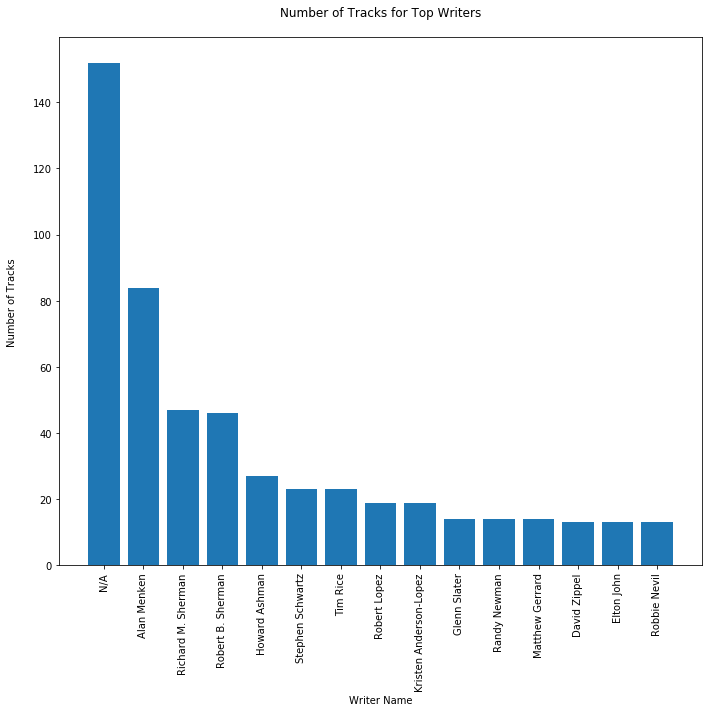

In [162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.bar(top_writers['writer_name'], top_writers['songs_per_writer'])
plt.title("Number of Tracks for Top Writers\n")
plt.xlabel("Writer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Tracks\n")

plt.tight_layout()
plt.show()

In [160]:
#popular_performers
df = pd.DataFrame()
df['songs_per_performer'] = [len([songs['performer(s)'][i] for i in range(len(songs['performer(s)'])) if performer in songs['performer(s)'][i]]) for performer in unique_performers]
df['performer_name'] = unique_performers

df.head()

,songs_per_performer,performer_name
0,1,98 Degrees
1,3,Aaron Lohr
2,1,Aaron Spaan
3,1,Aaryn Doyle
4,1,Adam S. Shen


In [161]:
top_performers = df.sort_values('songs_per_performer', ascending=False)[:15]
top_performers

,songs_per_performer,performer_name
102,38,Cast
595,31,chorus
118,22,Chorus
167,20,Dove Cameron
522,16,Sofia Carson
588,16,Zac Efron
273,15,Jim Cummings
574,14,Vanessa Hudgens
10,14,Alan Menken
159,12,Dick Van Dyke


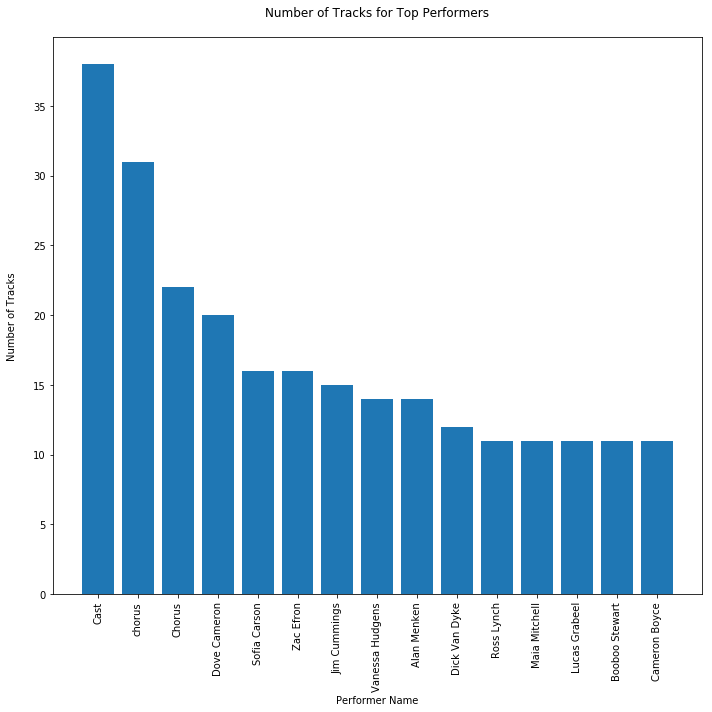

In [164]:
plt.figure(figsize=(10,10))

plt.bar(top_performers['performer_name'], top_performers['songs_per_performer'])
plt.title("Number of Tracks for Top Performers\n")
plt.xlabel("Performer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Tracks\n")

plt.tight_layout()
plt.show()

In [176]:
top_writer_names = list(top_writers['writer_name'])
top_writer_names = top_writer_names[1:]
top_writer_names

['Alan Menken',
 'Richard M. Sherman',
 'Robert B. Sherman',
 'Howard Ashman',
 'Stephen Schwartz',
 'Tim Rice',
 'Robert Lopez',
 'Kristen Anderson-Lopez',
 'Glenn Slater',
 'Randy Newman',
 'Matthew Gerrard',
 'David Zippel',
 'Elton John',
 'Robbie Nevil']

In [175]:
writer_stats = pd.DataFrame()

writer_stats['mean_num_verses'] = [np.mean([songs['num_verses'][i] for i in range(len(songs['writer(s)'])) if writer in songs['writer(s)'][i]]) for writer in top_writer_names]
writer_stats['mean_num_words'] = [np.mean([songs['num_words'][i] for i in range(len(songs['writer(s)'])) if writer in songs['writer(s)'][i]]) for writer in top_writer_names]
writer_stats['writer_name'] = top_writer_names

writer_stats

,mean_num_verses,mean_num_words,writer_name
0,37.595238,213.940476,Alan Menken
1,27.553191,156.510638,Richard M. Sherman
2,27.695652,156.413043,Robert B. Sherman
3,43.074074,242.518519,Howard Ashman
4,40.739130,234.739130,Stephen Schwartz
5,37.391304,216.173913,Tim Rice
6,38.789474,239.842105,Robert Lopez
7,38.789474,239.842105,Kristen Anderson-Lopez
8,32.714286,187.142857,Glenn Slater
9,32.714286,184.785714,Randy Newman


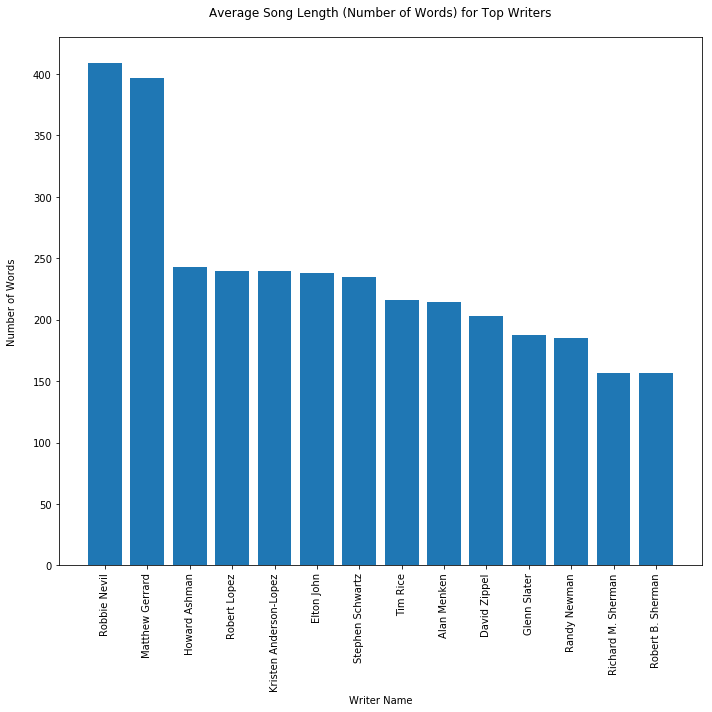

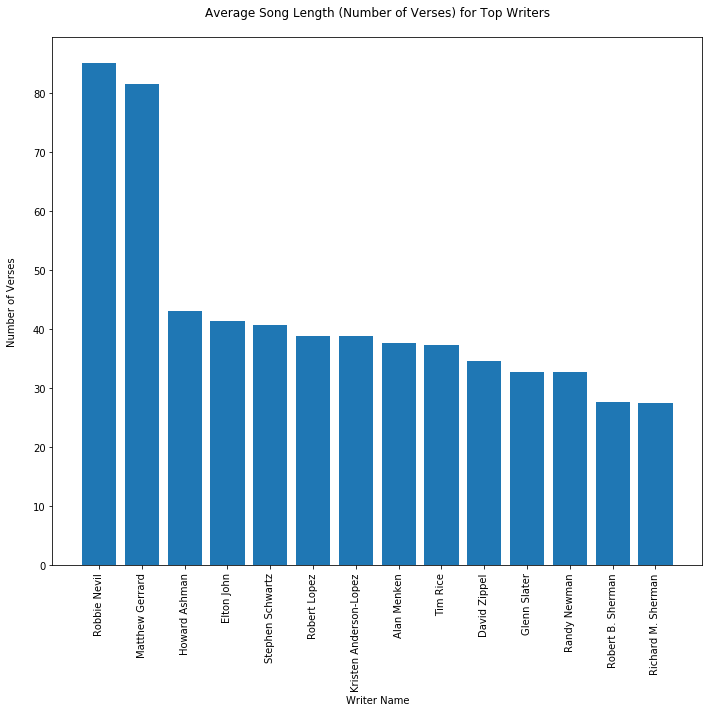

In [179]:
plt.figure(figsize=(10,10))

writer_stats = writer_stats.sort_values('mean_num_words',ascending=False)

plt.bar(writer_stats['writer_name'], writer_stats['mean_num_words'])
plt.title("Average Song Length (Number of Words) for Top Writers\n")
plt.xlabel("Writer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Words\n")

plt.tight_layout()
plt.show()

##############################################

plt.figure(figsize=(10,10))

writer_stats = writer_stats.sort_values('mean_num_verses',ascending=False)

plt.bar(writer_stats['writer_name'], writer_stats['mean_num_verses'])
plt.title("Average Song Length (Number of Verses) for Top Writers\n")
plt.xlabel("Writer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Verses\n")

plt.tight_layout()
plt.show()

In [177]:
top_performer_names = list(top_performers['performer_name'])
top_performer_names = top_performer_names[3:]
top_performer_names

['Dove Cameron',
 'Sofia Carson',
 'Zac Efron',
 'Jim Cummings',
 'Vanessa Hudgens',
 'Alan Menken',
 'Dick Van Dyke',
 'Ross Lynch',
 'Maia Mitchell',
 'Lucas Grabeel',
 'Booboo Stewart',
 'Cameron Boyce']

In [174]:
performer_stats = pd.DataFrame()

performer_stats['mean_num_verses'] = [np.mean([songs['num_verses'][i] for i in range(len(songs['performer(s)'])) if performer in songs['performer(s)'][i]]) for performer in top_performer_names]
performer_stats['mean_num_words'] = [np.mean([songs['num_words'][i] for i in range(len(songs['performer(s)'])) if performer in songs['performer(s)'][i]]) for performer in top_performer_names]
performer_stats['performer_name'] = top_performer_names

performer_stats

,mean_num_verses,mean_num_words,performer_name
0,65.000000,377.500000,Dove Cameron
1,69.187500,397.312500,Sofia Carson
2,53.250000,303.062500,Zac Efron
3,29.066667,168.133333,Jim Cummings
4,49.000000,275.000000,Vanessa Hudgens
5,26.000000,129.642857,Alan Menken
6,35.166667,195.916667,Dick Van Dyke
7,47.363636,292.181818,Ross Lynch
8,46.727273,292.818182,Maia Mitchell
9,58.636364,304.545455,Lucas Grabeel


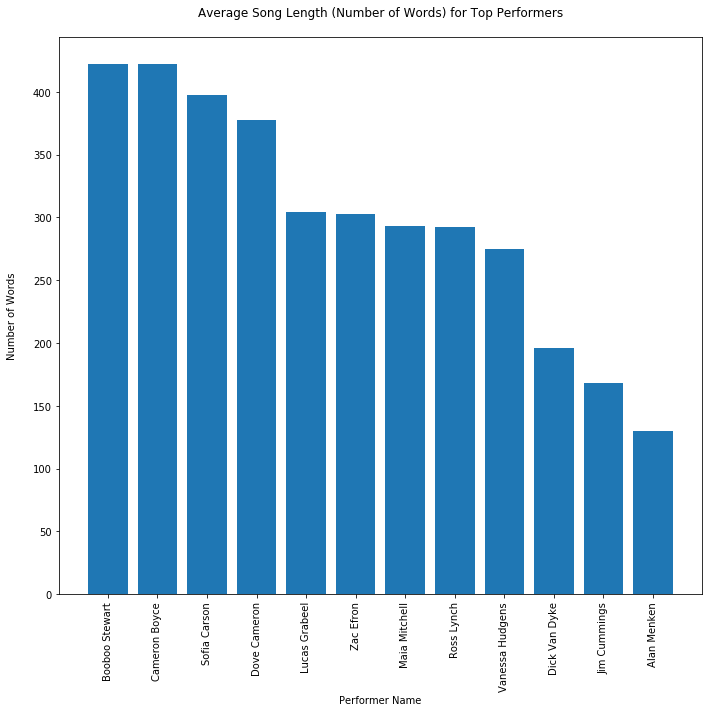

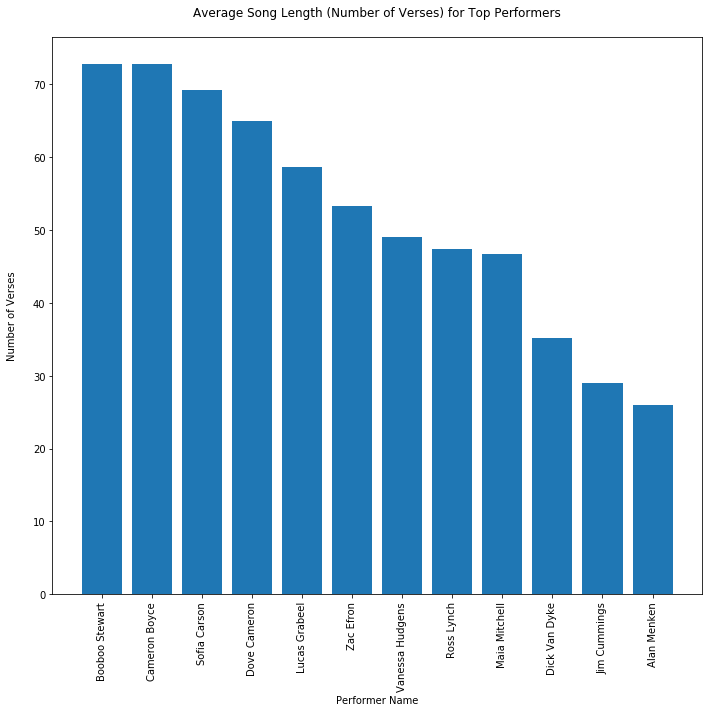

In [180]:
plt.figure(figsize=(10,10))

performer_stats = performer_stats.sort_values('mean_num_words',ascending=False)

plt.bar(performer_stats['performer_name'], performer_stats['mean_num_words'])
plt.title("Average Song Length (Number of Words) for Top Performers\n")
plt.xlabel("Performer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Words\n")

plt.tight_layout()
plt.show()


##############################3

plt.figure(figsize=(10,10))

performer_stats = performer_stats.sort_values('mean_num_verses',ascending=False)

plt.bar(performer_stats['performer_name'], performer_stats['mean_num_verses'])
plt.title("Average Song Length (Number of Verses) for Top Performers\n")
plt.xlabel("Performer Name")
plt.xticks(rotation=90)
plt.ylabel("Number of Verses\n")

plt.tight_layout()
plt.show()